# Time-explicit LCA to test speed of two approaches with long and complicated timelines, that also include loops


In [1]:
import bw2data as bd
bd.projects

Brightway2 projects manager with 21 objects, including:
	IUFRO_fp_with_eol_bw2
	IUFRO_fp_with_eol_bw25
	bw25_EV_setac
	bw25_ecoinvent3.8
	bw25_ecoinvent3.9
	bw25_ei310
	bw25_ei39
	bw25_premise
	bw25_premise_background_v2
	bw2_ei10
Use `sorted(projects)` to get full list, `projects.report()` to get
	a report on all projects.

In [2]:
if 'bw25_premise_background_v2' not in bd.projects:
    import bw2io as bi
    bi.backup.restore_project_directory(fp= '/Users/ajakobs/Documents/prospective_dynamic_lca/brightway2-project-bw25_premise_background_v2-backup.26-March-2024-01-40PM.tar.gz',
                                    overwrite_existing=True)

In [2]:
bd.projects.set_current('bw25_premise_background_v2')

In [4]:
db_2020 = bd.Database("db_2020")
db_2030 = bd.Database("db_2030")
db_2040 = bd.Database("db_2040")

## Case study setup


get keys of biosphere3 flows:

In [30]:
biosphere = bd.Database("biosphere3")
co2_fossil = [x for x in biosphere if "Carbon dioxide, fossil" in x['name'] and x["categories"]== ('air',)][0]
ch4_fossil = [x for x in biosphere if "Methane, fossil" in x['name'] and x["categories"]== ('air',)][0]


select background (db_2020) technosphere flows:

In [32]:
glider_production = bd.get_activity(("db_2020", "133b33cc867081af144475d62179286b"))
powertrain_production = bd.get_activity(
    ("db_2020", "f6d3f0b01e4a38c055e3c5c1356a4bba")
)  # eol included
battery_production = bd.get_activity(("db_2020", "ba87aff6361d99be2636e8c59e55a5b2"))
electricity_production = bd.get_activity(
    ("db_2020", "fec93a95a9a84d7fa0ede9c3082bb79f")
)
glider_eol = bd.get_activity(("db_2020", "f8114e0ff375b3c6d72ccfa49f79e44d"))
battery_eol = bd.get_activity(("db_2020", "82ebcdf42e8512cbe00151dda6210d29"))

Foreground system: 
- multiple levels in foreground (not only 1 EV life cycle level)
- biosphere emissions with TD in foreground
- loop B-C-E
- connections with background processes from premise db on multiple levels
- no TD in background, see below

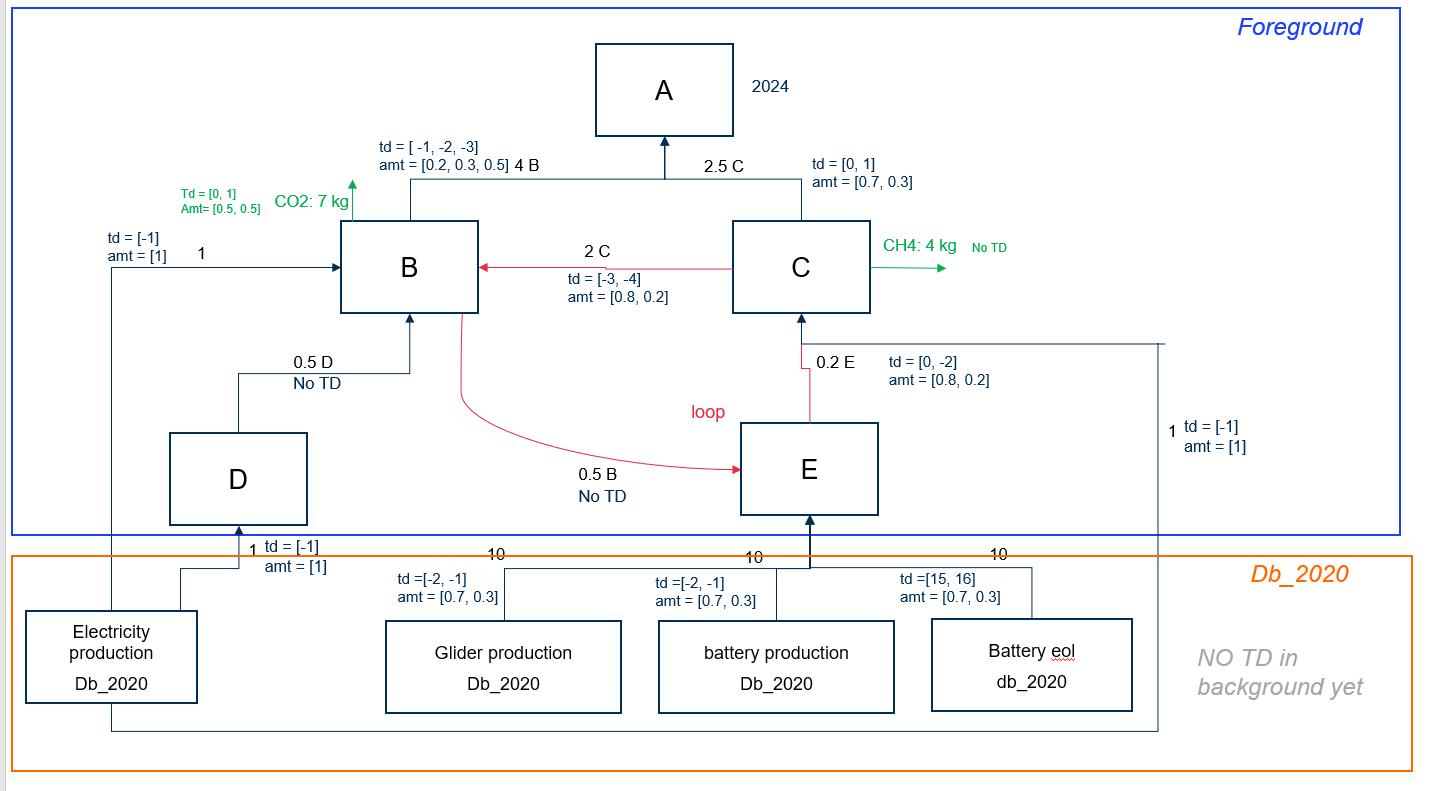

In [34]:
if 'foreground' in bd.databases:
    del bd.databases["foreground"] # to make sure we create the foreground from scratch
import numpy as np
from bw_temporalis import TemporalDistribution
bd.Database("foreground").write(
        {
            ("foreground", "A"): {
                "name": "process a",
                "location": "somewhere",
                "reference product": "a",
                "exchanges": [
                    {
                        "amount": 1,
                        "type": "production",
                        "input": ("foreground", "A"),
                    },

                    {
                        "amount": 4,  
                        "type": "technosphere",
                        "input": ("foreground", "B"),
                        'temporal_distribution': TemporalDistribution(
                                date=np.array([-1, -2, -3], dtype="timedelta64[Y]"), 
                                amount=np.array([0.2, 0.3, 0.5])  
                        ),
                    },
                    {
                        "amount": 2.5,  
                        "type": "technosphere",
                        "input": ("foreground", "C"),
                        'temporal_distribution': TemporalDistribution(
                                date=np.array([0, 1], dtype="timedelta64[Y]"), 
                                amount=np.array([0.7, 0.3])  
                        ),
                    },
                ],
            },

            ("foreground", "B"): {
                "name": "process b",
                "location": "somewhere",
                "reference product": "b",
                "exchanges": [
                    {
                        "amount": 1,
                        "type": "production",
                        "input": ("foreground", "B"),
                    },
                    {
                        "amount": 7,  
                        "type": "biosphere",
                        "input": co2_fossil.key,
                        'temporal_distribution': TemporalDistribution(
                                date=np.array([0, 1], dtype="timedelta64[Y]"), 
                                amount=np.array([0.5, 0.5])  
                        ),
                    },
                    {
                        "amount": 2,  
                        "type": "technosphere",
                        "input": ("foreground", "C"),
                        "temporal_distribution": TemporalDistribution(
                                date=np.array([-3,-4], dtype="timedelta64[Y]"), 
                                amount=np.array([0.8, 0.2])  
                        ),
                    },
                    {
                        "amount": 0.5,  
                        "type": "technosphere",
                        "input": ("foreground", "D"),
                    },

                    {
                        "amount": 1,  
                        "type": "technosphere",
                        "input": electricity_production.key,
                        "temporal_distribution": TemporalDistribution(
                                date=np.array([-1], dtype="timedelta64[Y]"), 
                                amount=np.array([1])  
                        ),
                    },
                ],
            },


            ("foreground", "C"): {
                "name": "process c",
                "location": "somewhere",
                "reference product": "c",
                "exchanges": [
                    {
                        "amount": 1,
                        "type": "production",
                        "input": ("foreground", "C"),
                    },
                    {
                        "amount": 4,  
                        "type": "biosphere",
                        "input": ch4_fossil.key,
                    },

                    {
                        "amount": 0.2,  
                        "type": "technosphere",
                        "input": ("foreground", "E"),
                        "temporal_distribution": TemporalDistribution(
                                date=np.array([0,-2], dtype="timedelta64[Y]"), 
                                amount=np.array([0.8, 0.2])  
                        ),
                    },

                    {
                        "amount": 1,  
                        "type": "technosphere",
                        "input": electricity_production.key,
                        "temporal_distribution": TemporalDistribution(
                                date=np.array([-1], dtype="timedelta64[Y]"), 
                                amount=np.array([1])  
                        ),
                    },
   
                ],
            },

            ("foreground", "D"): {
                "name": "process d",
                "location": "somewhere",
                "reference product": "d",
                "exchanges": [
                    {
                        "amount": 1,
                        "type": "production",
                        "input": ("foreground", "D"),
                    },
                    {
                        "amount": 1,  
                        "type": "technosphere",
                        "input": electricity_production.key,
                        "temporal_distribution": TemporalDistribution(
                                date=np.array([-1], dtype="timedelta64[Y]"), 
                                amount=np.array([1])  
                        ),
                    },
  
                ],
            },

            ("foreground", "E"): {
                "name": "process e",
                "location": "somewhere",
                "reference product": "e",
                "exchanges": [
                    {
                        "amount": 1,
                        "type": "production",
                        "input": ("foreground", "E"),
                    },
               
                    {
                        "amount": 0.5,  #loop via B-C-E
                        "type": "technosphere",
                        "input": ("foreground", "B"),
                       
                    },

                    {
                        "amount": 10,  
                        "type": "technosphere",
                        "input": glider_production.key,
                        "temporal_distribution": TemporalDistribution(
                                date=np.array([-2, -1], dtype="timedelta64[Y]"), 
                                amount=np.array([0.7, 0.3])  
                        ),
                    },
                    {
                        "amount": 10,  
                        "type": "technosphere",
                        "input": battery_production.key,
                        "temporal_distribution": TemporalDistribution(
                                date=np.array([-2, -1], dtype="timedelta64[Y]"), 
                                amount=np.array([0.7, 0.3])  
                        ),
                    },
                    {
                        "amount": 10,  
                        "type": "technosphere",
                        "input": battery_eol.key,
                        "temporal_distribution": TemporalDistribution(
                                date=np.array([15, 16], dtype="timedelta64[Y]"), 
                                amount=np.array([0.7, 0.3])  
                        ),
                    },
   
                ],
            },
        },
)




Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 5/5 [00:00<?, ?it/s]

Vacuuming database 


additing TDs into the background yields a "TypeError: 'ReadOnlyExchange' object does not support item assignment", which I can't figure out how to solve -> no TD in the background databases at the moment...

In [29]:
# from bw_temporalis import TemporalDistribution
# import numpy as np
# steel = bd.get_activity(('db_2020', '1e1abb2f1ff180c2ad4a863dd90e8613'))
# for exc in steel.technosphere():
#     print(exc)
#     if exc.input["name"]=='market group for natural gas, high pressure':
#         exc["temporal_distribution"]= TemporalDistribution(
#                                 date=np.array([-5], dtype="timedelta64[Y]"), 
#                                 amount=np.array([1])  
#                         ),
#         exc.save()

Exchange: 0.0011936331866309047 cubic meter 'market group for natural gas, high pressure' (cubic meter, Europe without Switzerland, None) to 'steel production, converter, unalloyed' (kilogram, RER, None)>


TypeError: 'ReadOnlyExchange' object does not support item assignment

In [ ]:
# same code would work for a foreground db
# b = bd.get_activity( ('foreground', 'B'))
# for exc in b.technosphere():
#     print(exc)
#     if exc.input["name"]=='process d':
#         exc["temporal_distribution"]= TemporalDistribution(
#                                 date=np.array([-5], dtype="timedelta64[Y]"), 
#                                 amount=np.array([1])  
#                         ),
#         exc.save()

In [37]:
#check foreground TDs
foreground = bd.Database("foreground")
for act in foreground:
    print(act)
    for exc in act.technosphere():
        print("---", exc)
        print("--------", exc.get('temporal_distribution', 'no TD'))
    print("")

'process e' (None, somewhere, None)
--- Exchange: 0.5 None 'process b' (None, somewhere, None) to 'process e' (None, somewhere, None)>
-------- no TD
--- Exchange: 10 kilogram 'market for glider, passenger car' (kilogram, GLO, None) to 'process e' (None, somewhere, None)>
-------- TemporalDistribution instance with 2 values and total: 1
--- Exchange: 10 kilogram 'battery production, Li-ion, LiMn2O4, rechargeable, prismatic' (kilogram, GLO, None) to 'process e' (None, somewhere, None)>
-------- TemporalDistribution instance with 2 values and total: 1
--- Exchange: 10 kilogram 'market for used Li-ion battery' (kilogram, GLO, None) to 'process e' (None, somewhere, None)>
-------- TemporalDistribution instance with 2 values and total: 1

'process c' (None, somewhere, None)
--- Exchange: 0.2 None 'process e' (None, somewhere, None) to 'process c' (None, somewhere, None)>
-------- TemporalDistribution instance with 2 values and total: 1
--- Exchange: 1 kilowatt hour 'market group for electri

## LCA using `bw_timex`


As usual, we need to select a method:

In [38]:
method = ("EF v3.1", "climate change", "global warming potential (GWP100)")

`bw_timex` needs to know the representative time of the databases:

In [39]:
from datetime import datetime

database_dates = {
    "db_2020": datetime.strptime("2020", "%Y"),
    "db_2030": datetime.strptime("2030", "%Y"),
    "db_2040": datetime.strptime("2040", "%Y"),
    
    "foreground": "dynamic",  # flag databases that should be temporally distributed with "dynamic"
}

Let's create a `TimexLCA` object for our EV life cycle:

In [54]:
from bw_timex import TimexLCA
tlca = TimexLCA({("foreground", "A"): 1}, method, database_dates)

In [55]:
tlca.build_timeline()

C:\Users\MULLERA\OneDrive - VITO\Documents\04_Coding\tictac_lca\bw_timex\timex_lca.py:183: UserWarning: No edge filter function provided. Skipping all edges within background databases.
  warnings.warn(


Starting graph traversal
Calculation count: 225


In [ ]:
tlca.build_timeline(cutoff = 0.000001)

In [46]:
# first try without the expanded matrix 
tlca.lci(expand_technosphere=False)

In [47]:
tlca.dynamic_biosphere_matrix

<143354x534 sparse matrix of type '<class 'numpy.float64'>'
	with 728872 stored elements in Compressed Sparse Row format>

Taking a look at the `dynamic_inventory` that was now created, we can see that it has more rows (emissions) than our usual biosphere3 flows. Instead of one row for each emission in the biosphere database we now get one row for each emission at each point in time.

In [48]:
tlca.dynamic_inventory

<143354x534 sparse matrix of type '<class 'numpy.float64'>'
	with 657212 stored elements in Compressed Sparse Row format>

In [49]:
tlca.dynamic_inventory_df

date       amount  flow  activity
0      1981-01-01     1.600000  1652     25969
2      1982-01-01     6.400000  1652     25972
1      1982-01-01     1.600000  1652     25973
1749   1983-01-01  2583.186020  1909     25976
1750   1983-01-01  1627.513900  1909     25975
...           ...          ...   ...       ...
656286 2041-01-01   -11.067632  2845     26498
655846 2041-01-01   -77.675529  1756     26498
655602 2041-01-01   -82.478528   923     26498
656638 2041-01-01   -82.639892  3613     26498
655897 2041-01-01  -254.919584  1909     26498

[657212 rows x 4 columns]

In [50]:
# now let's calculate the lci with matrix expansion
tlca.lci(expand_technosphere=True)

In [51]:
tlca.dynamic_biosphere_matrix

<143354x72613 sparse matrix of type '<class 'numpy.float64'>'
	with 357189 stored elements in Compressed Sparse Row format>

In [52]:
tlca.dynamic_inventory

<143354x72613 sparse matrix of type '<class 'numpy.float64'>'
	with 321833 stored elements in Compressed Sparse Row format>

In [53]:
tlca.dynamic_inventory_df

date        amount  flow  activity
0      1981-01-01  2.993141e-07  1652     98449
1      1982-01-01  3.309275e-06  1652     98451
1747   1983-01-01  9.514239e-04  1909     98454
1748   1983-01-01  6.089223e-04  1909     98453
1645   1983-01-01  2.314367e-04  1756     98454
...           ...           ...   ...       ...
320908 2041-01-01 -1.328116e+00  2845     98445
320468 2041-01-01 -9.321064e+00  1756     98445
320224 2041-01-01 -9.897424e+00   923     98445
321260 2041-01-01 -9.916787e+00  3613     98445
320519 2041-01-01 -3.059035e+01  1909     98445

[321833 rows x 4 columns]

In [ ]:
tlca.lci(build_dynamic_biosphere=False)
tlca.static_lcia()
tlca.score   #kg CO2-eq

15697.67132351153

## Dynamic Characterization
In addition to the standard static characterization, the time-explicit, dynamic inventory generated by a `TimexLCA` allows for dynamic characterization. Users can provide their own dynamic characterization functions and link them to corresponding biosphere flows (see example on [dynamic characterization](https://github.com/TimoDiepers/timex/blob/main/notebooks/example_simple_dynamic_characterization.ipynb)), or use the ones we provide out of the box. 

We provide two different metrics for dynamic LCIA of Climate Change: Radiative forcing [W/m2] and Global Warming Potential (GWP) [kg CO2-eq]. For both of these metrics, we have parameterized dynamic characterization functions for all GHG's that [IPCC AR6](https://www.ipcc.ch/report/ar6/wg1/chapter/chapter-7/) provides data for.

For the dynamic characterization, users can also choose the length of the considered time horizon (`time_horizon`) and whether it is a fixed time horizon (`fixed_time_horizon`). Fixed means that the time horizon for all emissions (no matter when they occur) starts counting at the time of the functional unit, resulting in shorter time horizons for emissions occuring later. If the time horizon is not fixed (this is what conventional impact assessment factors assume), it starts counting from the timing of the emission.


### Radiative forcing


Let's characterize our dynamic inventory, regarding radiative forcing with a fixed time horizon and the default time horizon length of 100 years:

In [32]:
tlca.dynamic_lcia(metric="radiative_forcing", fixed_time_horizon=True)

/Users/ajakobs/Documents/prospective_dynamic_lca/bw_timex/bw_timex/dynamic_characterization.py:71: UserWarning: No custom dynamic characterization functions provided. Using default dynamic characterization functions based on IPCC AR6 meant to work with biosphere3 flows. The flows that are characterized are based on the selection of the initially chosen impact category: ('EF v3.1', 'climate change', 'global warming potential (GWP100)'). You can look up the mapping in the bw_timex.dynamic_characterizer.characterization_functions.
  warnings.warn(


date        amount  flow  \
0      2022-01-01 05:49:12  4.281176e-43  1332   
149    2022-01-01 05:49:12  1.528897e-19   260   
150    2022-01-01 05:49:12 -6.357518e-19  3636   
151    2022-01-01 05:49:12  2.461282e-22  1656   
152    2022-01-01 05:49:12  1.754148e-19  1170   
...                    ...           ...   ...   
140225 2123-01-01 21:14:24  1.005114e-17   444   
140224 2123-01-01 21:14:24  3.203941e-21  4261   
140223 2123-01-01 21:14:24  3.410371e-21  4686   
140246 2123-01-01 21:14:24  5.082378e-18   438   
140295 2123-01-01 21:14:24  2.810623e-47  1332   

                                                flow_name  activity  \
0                      Ethane, 1,1,1-trifluoro-, HFC-143a     98282   
149                                   Tetrachloroethylene     98282   
150              Carbon dioxide, to soil or biomass stock     98281   
151                            Methane, monochloro-, R-40     98283   
152                                Carbon dioxide, fossil     98281   
...                                                   ...       ...   
140225                        Methane, trifluoro-, HFC-23     98308   
140224  Ethane, 1,1,2-trichloro-1,2,2-trifluoro-, CFC-113     98309   
140223                                Dinitrogen monoxide     98309   
140246                                    Methane, fossil     98308   
140295                 Ethane, 1,1,1-trifluoro-, HFC-143a     98309   

                                      activity_name    amount_sum  
0       (db_2020, ba87aff6361d99be2636e8c59e55a5b2)  4.281176e-43  
149     (db_2020, ba87aff6361d99be2636e8c59e55a5b2)  2.138694e-12  
150     (db_2020, 133b33cc867081af144475d62179286b)  2.138693e-12  
151     (db_2020, f6d3f0b01e4a38c055e3c5c1356a4bba)  2.138693e-12  
152     (db_2020, 133b33cc867081af144475d62179286b)  2.138693e-12  
...                                             ...           ...  
140225  (db_2020, 82ebcdf42e8512cbe00151dda6210d29)  1.351929e-09  
140224  (db_2020, f8114e0ff375b3c6d72ccfa49f79e44d)  1.351929e-09  
140223  (db_2020, f8114e0ff375b3c6d72ccfa49f79e44d)  1.351929e-09  
140246  (db_2020, 82ebcdf42e8512cbe00151dda6210d29)  1.351929e-09  
140295  (db_2020, f8114e0ff375b3c6d72ccfa49f79e44d)  1.351996e-09  

[140296 rows x 7 columns]

The method call returns a dataframe of all the individual emissions at their respective timesteps, but we can also just look at the overall score:

In [27]:
# inventory from timeline
tlca.dynamic_score #W/m2 (radiative forcing)

1.3519955746298651e-09

In [33]:
tlca.dynamic_score #W/m2 (radiative forcing)

1.351995574629866e-09

To visualize the results, we provide a simple plotting functions:

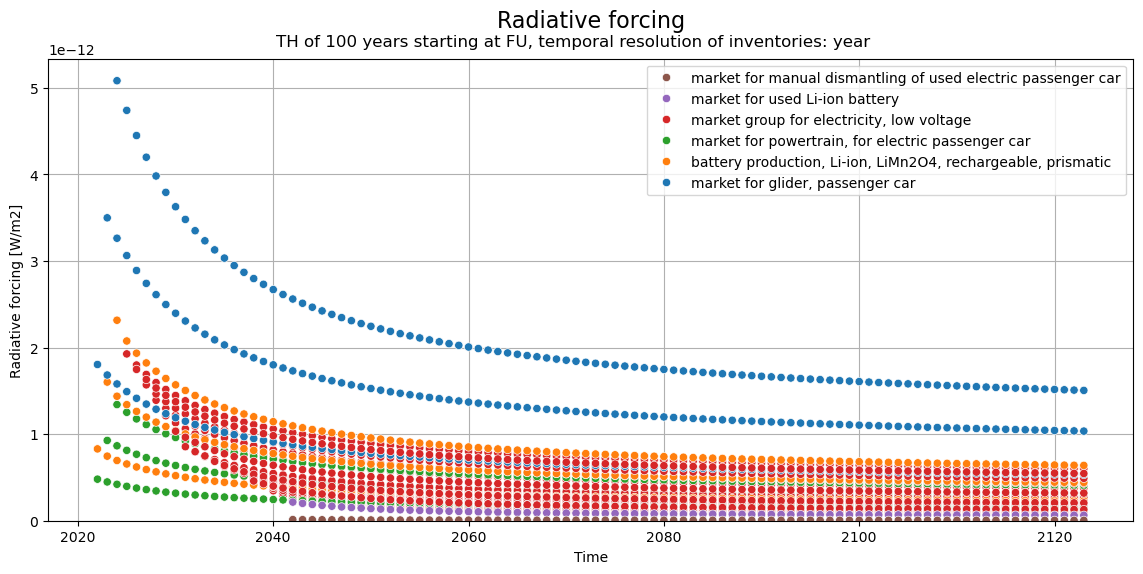

In [34]:
tlca.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True)

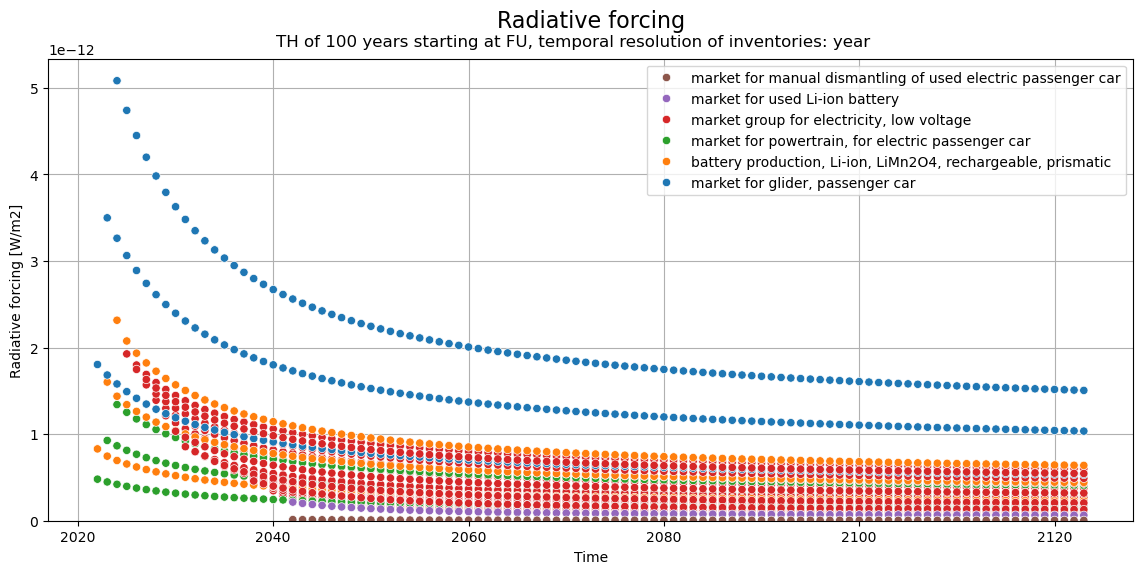

In [ ]:
tlca.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True)

Without summing up the emissions within the activity, one can see that there are also negative emissions in the system, which stem from the premise-induced BECCS in the future electricity production:

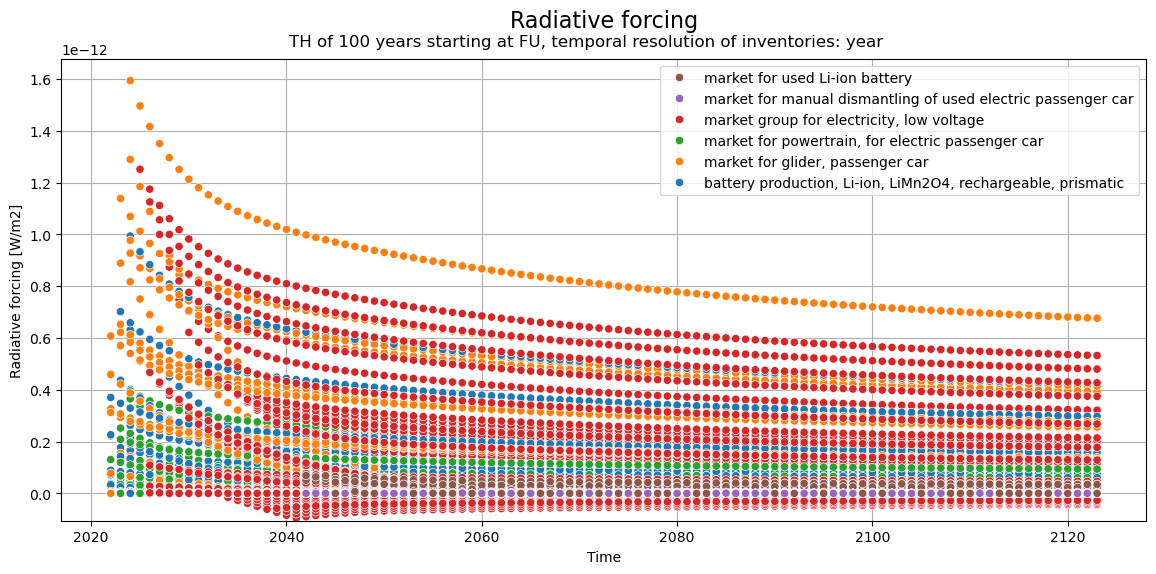

In [ ]:
tlca.plot_dynamic_characterized_inventory()  

There is also a flag to plot the cumulative radiative forcing:

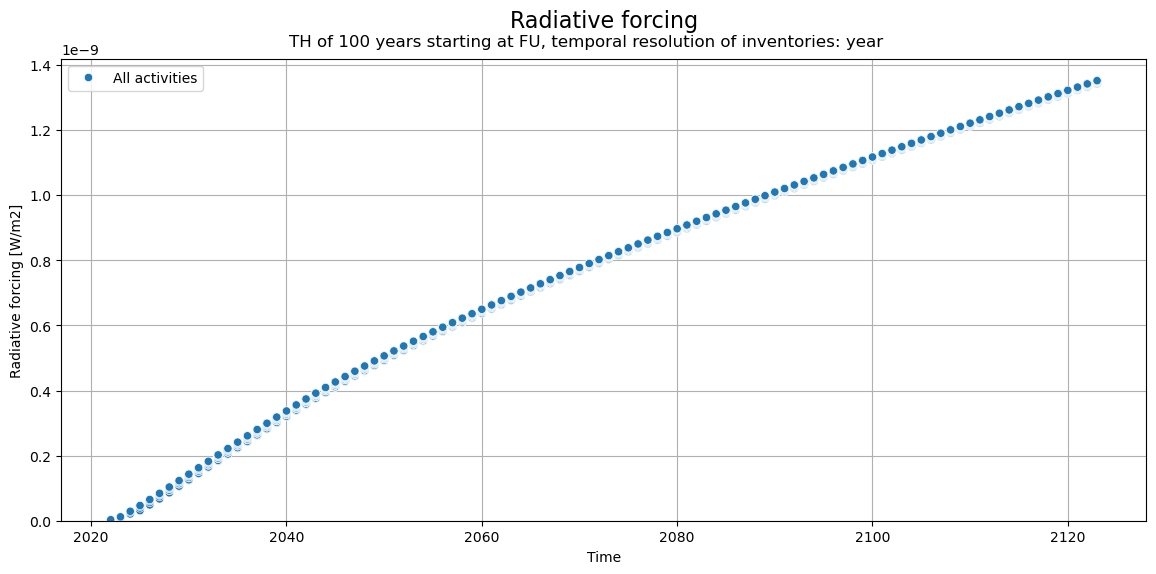

In [ ]:
tlca.plot_dynamic_characterized_inventory(sum_activities= True, cumsum=True)

### GWP


Similar options are available for the metric GWP, which compares the radiative forcing of a GHG to that of CO2 over a certain time horizon (commonly 100 years, but it can be set flexibly in `time_horizon`).

In [ ]:
tlca.dynamic_lcia(metric="GWP", fixed_time_horizon=False, time_horizon = 70)
tlca.dynamic_score #kg CO2-eq (GWP)

/Users/timodiepers/Documents/Coding/timex/bw_timex/dynamic_characterization.py:70: UserWarning: No custom dynamic characterization functions provided. Using default dynamic characterization functions based on IPCC AR6 meant to work with biosphere3 flows. The flows that are characterized are based on the selection of the initially chosen impact category: ('EF v3.1', 'climate change', 'global warming potential (GWP100)'). You can look up the mapping in the bw_timex.dynamic_characterizer.characterization_functions.
  warnings.warn(
/Users/timodiepers/Documents/Coding/timex/bw_timex/dynamic_characterization.py:122: UserWarning: Using bw_timex's default CO2 characterization function for GWP reference.
  warnings.warn(


15896.845450102795

Plotting the GWP results over time:

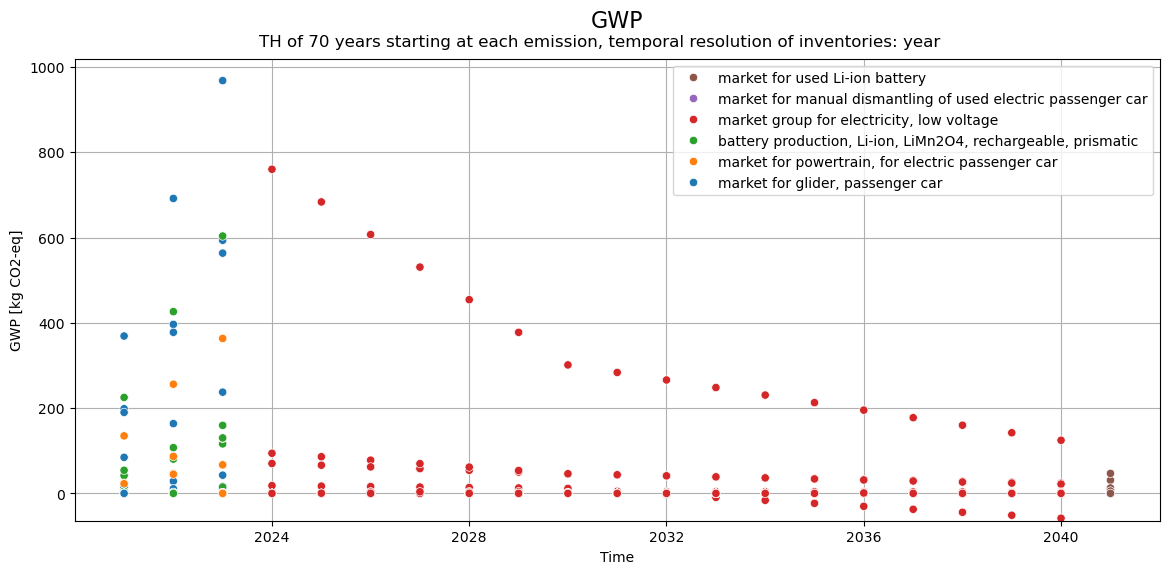

In [ ]:
tlca.plot_dynamic_characterized_inventory()

Cumulative:

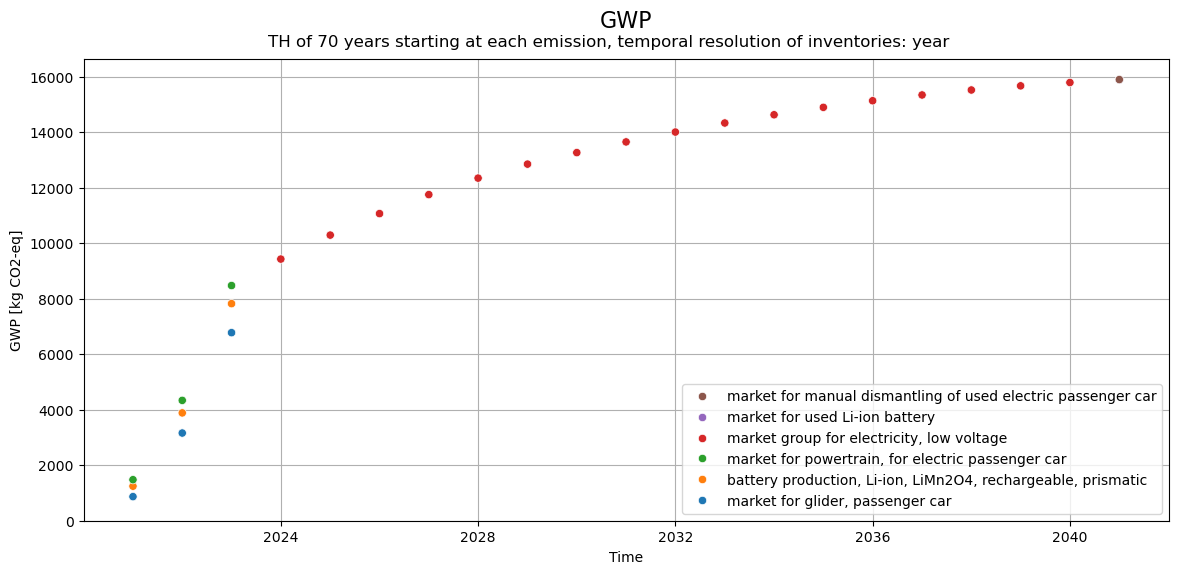

In [ ]:
tlca.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True, cumsum=True)

### Comparison of time-explicit results to static results
It's helpful to understand how the time-explicit results differ from those using static assessments. 

We compare the time-explicit results with those of an LCA for the year 2020 and 2040 for the standard GWP100 metric (time horizon=100 and no fixed time horizon). This means we neglect the additional differences of the time-explicit results that would arise from using dynamic LCIA. 

Time-explicit scores:

In [ ]:
tlca.dynamic_lcia(metric="GWP", fixed_time_horizon=False, time_horizon=100)
tlca.dynamic_score

/Users/timodiepers/Documents/Coding/timex/bw_timex/dynamic_characterization.py:70: UserWarning: No custom dynamic characterization functions provided. Using default dynamic characterization functions based on IPCC AR6 meant to work with biosphere3 flows. The flows that are characterized are based on the selection of the initially chosen impact category: ('EF v3.1', 'climate change', 'global warming potential (GWP100)'). You can look up the mapping in the bw_timex.dynamic_characterizer.characterization_functions.
  warnings.warn(
/Users/timodiepers/Documents/Coding/timex/bw_timex/dynamic_characterization.py:122: UserWarning: Using bw_timex's default CO2 characterization function for GWP reference.
  warnings.warn(


15446.54411830293

The 2020 (static) score has already been calculated by TimexLCA in the beginning, originally to set the priorities for the graph traversal. But we can still access the score:

In [ ]:
tlca.base_lca.score

31401.500705260198

However, further down we also want to look at what part of the life cycle has what contribution. To get this info, we need some more calculations:

In [ ]:
import bw2calc as bc

static_scores = {}
for e in ev_lifecycle.exchanges():
    if e.input == ev_lifecycle.key:
        continue
    lca = bc.LCA({e.input: e.amount}, method)
    lca.lci() # one could probably do this more efficiently by using .redo_lcia, but who doesn't like a 15s break :)
    lca.lcia()
    static_scores[e.input["name"]] = lca.score

Similarly, we calculate the 2040 (prospective) scores by just changing the database the exchanges point to:

In [ ]:
#first create a copy of the system and relink to processes from 2040 database
prospective_ev_lifecycle = ev_lifecycle.copy()

for exc in prospective_ev_lifecycle.exchanges():
    if exc.input == prospective_ev_lifecycle:
        continue
    exc.input = bd.get_node(
        **{
            "database": "db_2040",
            "name": exc.input["name"],
            "product": exc.input["reference product"],
            "location": exc.input["location"],
        }
    )
    exc.save()

prospective_scores = {}
for e in prospective_ev_lifecycle.exchanges():
    if e.input == prospective_ev_lifecycle.key:
        continue
    lca = bc.LCA({e.input: e.amount}, method)
    lca.lci()
    lca.lcia()
    prospective_scores[e.input["name"]] = lca.score

Lets compare the overall scores:

In [ ]:
print("Static score: ", sum(static_scores.values())) # should be the same as tlca.base_lca.score
print("Prospective score: ", sum(prospective_scores.values()))
print("Time-explicit score: ", tlca.dynamic_score)

Static score:  31401.500710765587
Prospective score:  7234.099282744538
Time-explicit score:  15446.54411830293


To better understand what's going on, let's plot the scores as a waterfall chart  based on timing of emission. Also, we can look at the "first-level contributions":

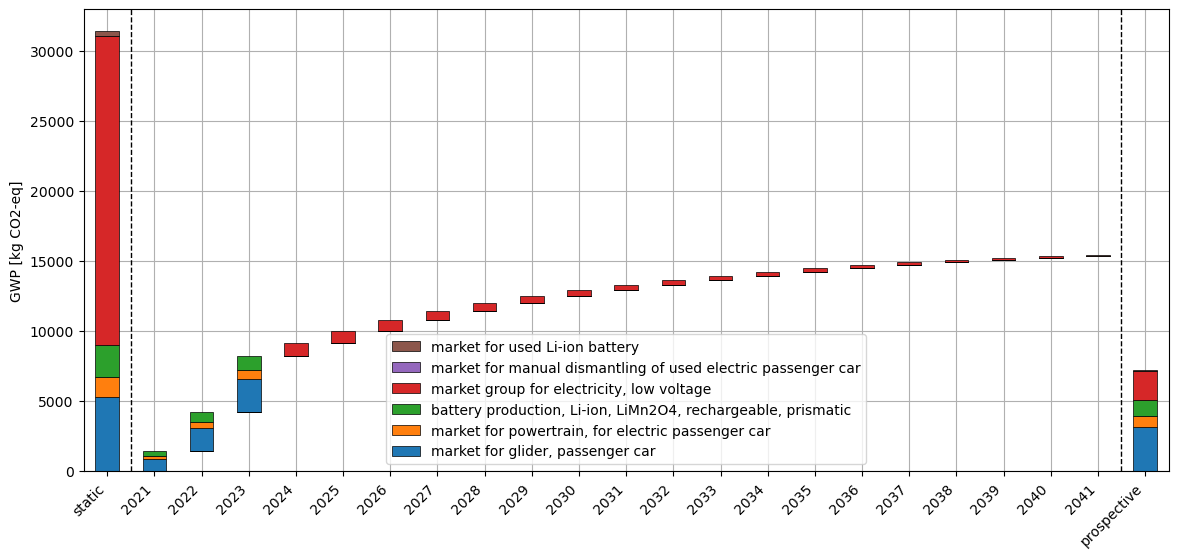

In [ ]:
from bw_timex.utils import plot_characterized_inventory_as_waterfall

order_stacked_activities = (
    [  # to sort stacked bars in waterfall plot chronologically from production to EoL
        "market for glider, passenger car",
        "market for powertrain, for electric passenger car",
        "battery production, Li-ion, LiMn2O4, rechargeable, prismatic",
        "market group for electricity, low voltage",
        "market for manual dismantling of used electric passenger car",
        "market for used Li-ion battery",
    ]
)

plot_characterized_inventory_as_waterfall(
    tlca.characterized_inventory,
    metric=tlca.metric,
    static_scores=static_scores,
    prospective_scores=prospective_scores,
    order_stacked_activities=order_stacked_activities,
)

One can see that the time-explicit results (in the middle) are somewhere in between the static and the prospective results. This makes sense as at each timestep, the underlying processes are sourced from progressively "cleaner" background databases, reaching a lower impact than if they are only sourced from the current database, but not so low as the prospective results, which are fully sourced from the most decarbonized database. Notably, the electricity consumption in the use-phase, modelled uniformly over the lifetime of the EV, contributes less and less to the score in the later years, since the electricity becomes cleaner in the future databases.